In [3]:
%cd ..

/Users/giorgiomastrotucci/Desktop/Lavoro/AssegnoDiRicerca/mlir_research


Loading and processing data (Stride 1 Only)...
Calculating speedup metrics...
Performing statistical analysis...
Generating plots...

Summary of Analysis (Stride 1 Only):
1. Average cycles speedup (scalar/vector): 1.35x
2. Average instructions speedup: 2.90x
3. Average cycles - Vector: 5401957.64, Scalar: 7293096.36
4. Best cycles speedup: 1.52x at Sparsity=50.0%
5. Worst cycles speedup: 1.08x at Sparsity=95.0%
6. High sparsity (>=80%) - Vector: 4330354.50, Scalar: 5158887.25, Ratio: 1.19x
7. Low sparsity (<=60%) - Vector: 6428654.00, Scalar: 9294357.25, Ratio: 1.45x

Analysis complete. All results saved to the 'analysis_output_stride1' directory.


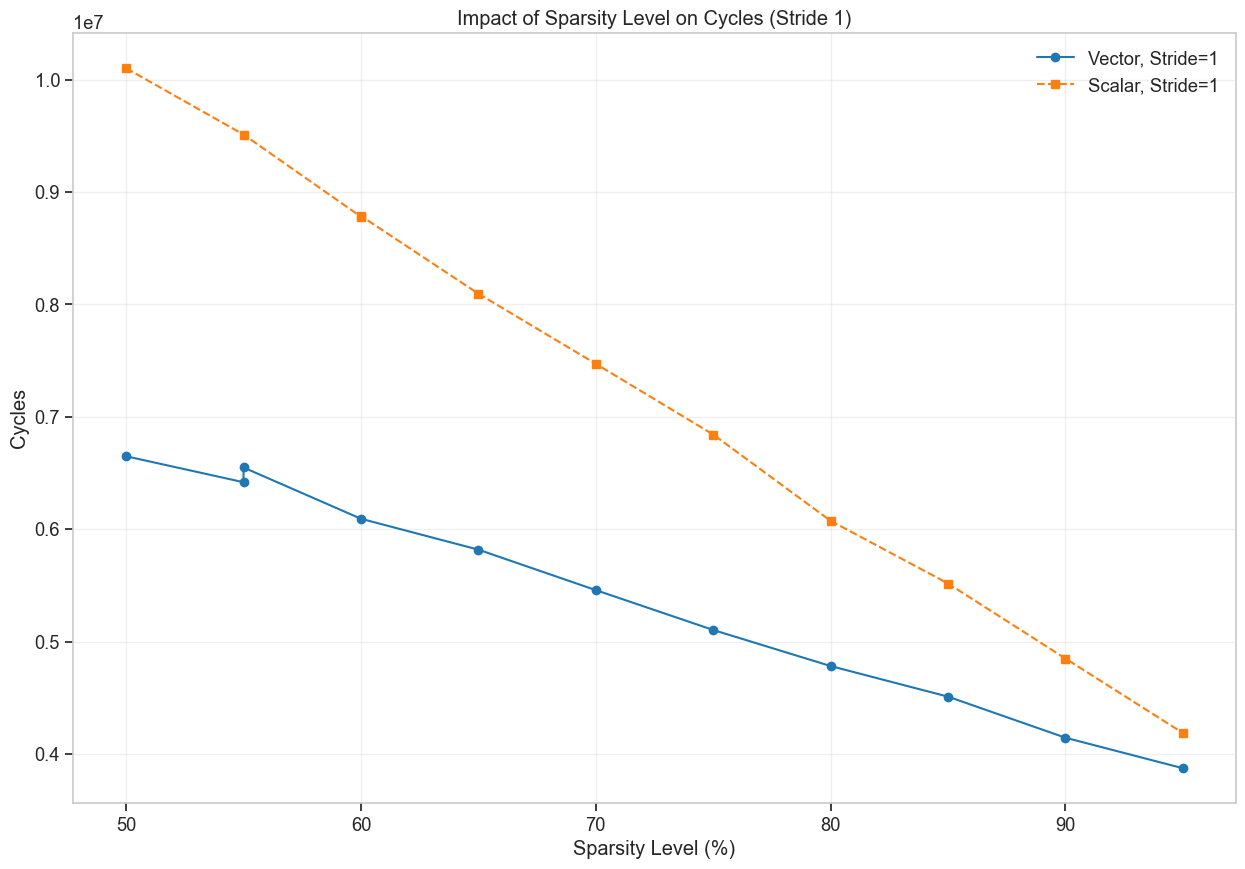

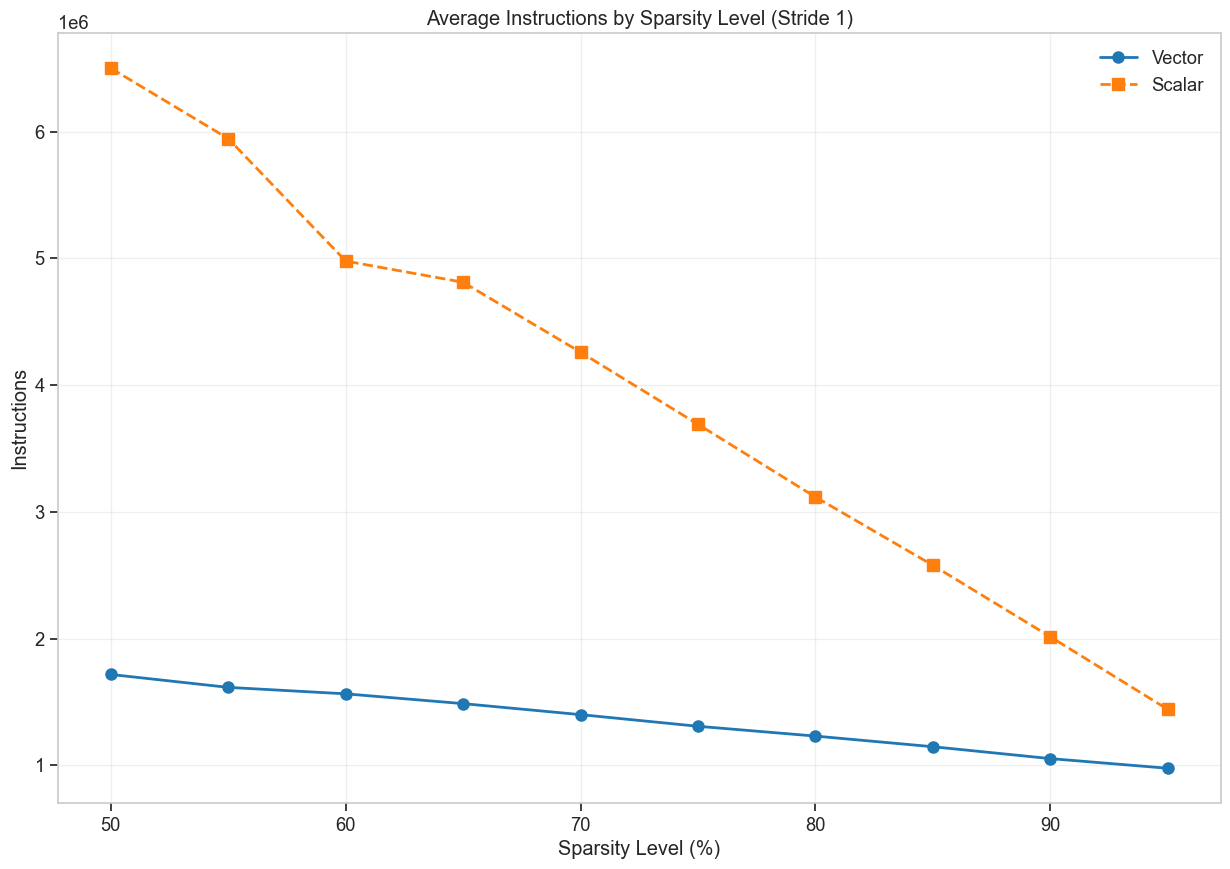

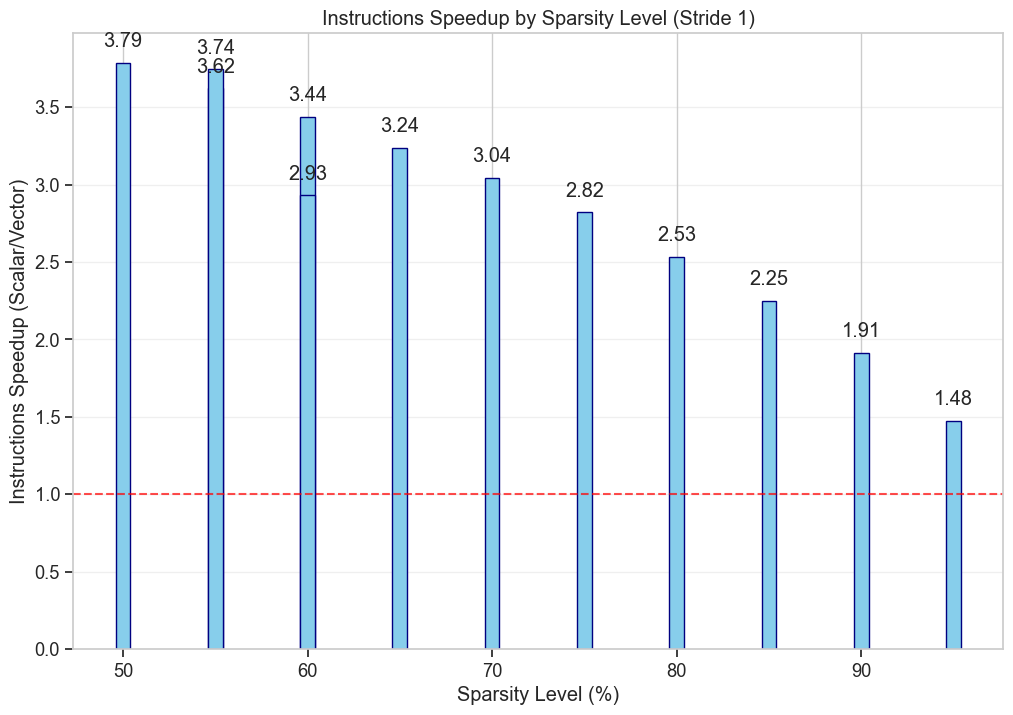

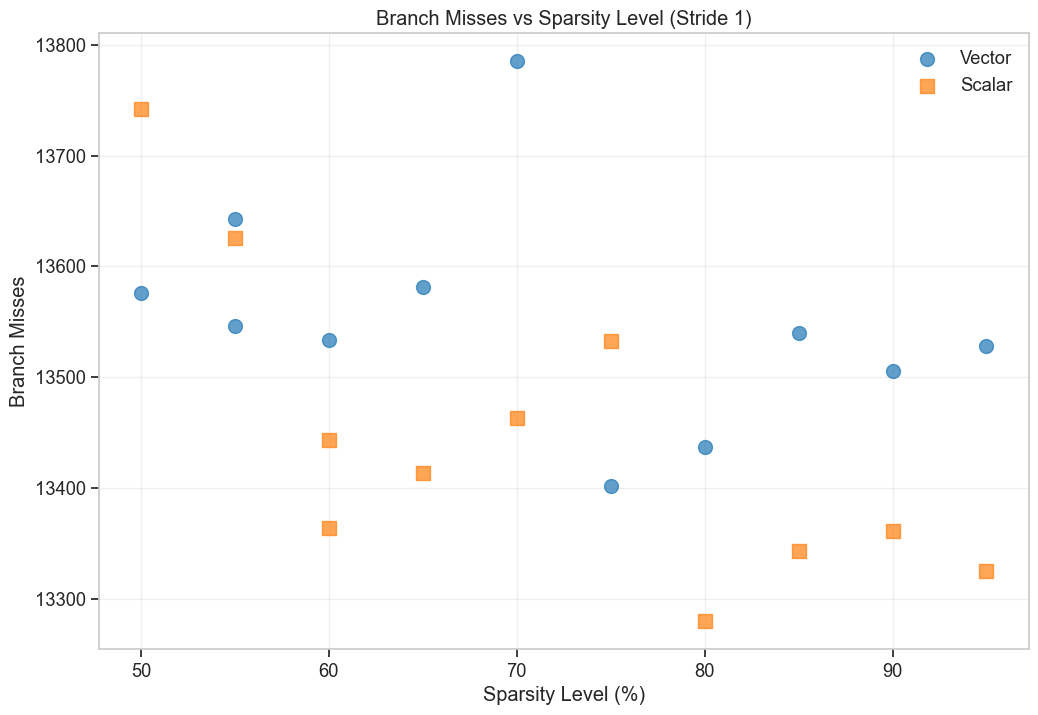

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Define the data processing functions
def load_and_process_data(vector_file, scalar_file):
    """
    Load and process the vector and scalar data from CSV files.
    Filter for stride 1 only.
    
    Parameters:
    vector_file (str): Path to the vector CSV file
    scalar_file (str): Path to the scalar CSV file
    
    Returns:
    tuple: (vector_df, scalar_df, combined_df)
    """
    # Load the CSV files
    vector_raw = pd.read_csv(vector_file)
    scalar_raw = pd.read_csv(scalar_file)
    
    # Filter for stride 1 only
    vector_raw = vector_raw[vector_raw['Stride'] == 1]
    scalar_raw = scalar_raw[scalar_raw['Stride'] == 1]
    
    # Add a column to identify the source
    vector_raw['Implementation'] = 'Vector'
    scalar_raw['Implementation'] = 'Scalar'
    
    # The data is stored in a sparse format where each row has only one metric value
    # Let's reshape it to have one row per experiment
    
    def reshape_df(df):
        # Initialize dictionary to store results
        results = {}
        
        # Extract unique combinations of Executable and Sparsity Level (stride is always 1)
        unique_exps = df[['Executable', 'Sparsity Level']].drop_duplicates()
        
        # For each unique experiment
        for _, exp in unique_exps.iterrows():
            exe = exp['Executable']
            sparsity = exp['Sparsity Level']
            
            # Create a key for this experiment
            key = (exe, sparsity)
            results[key] = {'Executable': exe, 
                           'Sparsity Level': sparsity, 
                           'Stride': 1,  # Fixed to 1
                           'Implementation': df['Implementation'].iloc[0]}
            
            # Find all rows for this experiment
            mask = ((df['Executable'] == exe) & 
                   (df['Sparsity Level'] == sparsity) & 
                   (df['Stride'] == 1))
            
            # For each metric, find the corresponding value
            for metric in ['Branch Misses', 'Branches', 'Context Switch', 'CPU Migration', 
                          'Cycles', 'Instructions', 'Page Faults']:
                metric_row = df[mask & ~df[metric].isna()]
                if len(metric_row) > 0:
                    results[key][f'{metric}_value'] = metric_row[metric].iloc[0]
        
        # Convert results to DataFrame
        return pd.DataFrame(list(results.values()))
    
    # Reshape both dataframes
    vector_df = reshape_df(vector_raw)
    scalar_df = reshape_df(scalar_raw)
    
    # Combine them
    combined_df = pd.concat([vector_df, scalar_df], ignore_index=True)
    
    return vector_df, scalar_df, combined_df

def calculate_speedup(vector_df, scalar_df):
    """
    Calculate speedup of vector implementation over scalar.
    
    Parameters:
    vector_df (DataFrame): Vector processed dataframe
    scalar_df (DataFrame): Scalar processed dataframe
    
    Returns:
    DataFrame: Speedup metrics
    """
    # Merge on Sparsity Level (stride is fixed at 1)
    merged = pd.merge(vector_df, scalar_df, 
                     on=['Sparsity Level'],
                     suffixes=('_vector', '_scalar'))
    
    # Calculate speedup metrics
    merged['cycles_speedup'] = merged['Cycles_value_scalar'] / merged['Cycles_value_vector']
    merged['instructions_speedup'] = merged['Instructions_value_scalar'] / merged['Instructions_value_vector']
    merged['branches_speedup'] = merged['Branches_value_scalar'] / merged['Branches_value_vector']
    
    return merged[['Sparsity Level', 'cycles_speedup', 
                  'instructions_speedup', 'branches_speedup']]

def perform_statistical_analysis(combined_df):
    """
    Perform statistical analysis to determine significance of relationships.
    Focus on sparsity impact only.
    """
    results = {}
    
    # For vector implementation
    vector_data = combined_df[combined_df['Implementation'] == 'Vector']
    
    # Correlation between sparsity and cycles for vector
    corr_sparsity_cycles_v = stats.pearsonr(
        vector_data['Sparsity Level'], vector_data['Cycles_value'])
    results['Vector Sparsity-Cycles Correlation'] = {
        'r': corr_sparsity_cycles_v[0],
        'p-value': corr_sparsity_cycles_v[1]
    }
    
    # For scalar implementation
    scalar_data = combined_df[combined_df['Implementation'] == 'Scalar']
    
    # Correlation between sparsity and cycles for scalar
    corr_sparsity_cycles_s = stats.pearsonr(
        scalar_data['Sparsity Level'], scalar_data['Cycles_value'])
    results['Scalar Sparsity-Cycles Correlation'] = {
        'r': corr_sparsity_cycles_s[0],
        'p-value': corr_sparsity_cycles_s[1]
    }
    
    # T-test comparing cycles between vector and scalar implementations
    vector_cycles = vector_data['Cycles_value']
    scalar_cycles = scalar_data['Cycles_value']
    ttest_result = stats.ttest_ind(vector_cycles, scalar_cycles)
    results['Vector vs Scalar Cycles T-test'] = {
        't-statistic': ttest_result[0],
        'p-value': ttest_result[1]
    }
    
    return results

def main():
    """
    Main function to execute the analysis for stride 1 only.
    """
    # File paths - update these with your actual file paths
    vector_file = 'all_results_vector.csv'
    scalar_file = 'all_results_scalar.csv'
    
    # Create output directory for plots if it doesn't exist
    output_dir = 'analysis_output_stride1'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Load and process data
    print("Loading and processing data (Stride 1 Only)...")
    vector_df, scalar_df, combined_df = load_and_process_data(vector_file, scalar_file)
    
    # Calculate speedup
    print("Calculating speedup metrics...")
    speedup_df = calculate_speedup(vector_df, scalar_df)
    
    # Perform statistical analysis
    print("Performing statistical analysis...")
    stats_results = perform_statistical_analysis(combined_df)
    
    # Generate plots
    print("Generating plots...")
    
    # Plot 1: Sparsity Impact
    plt.figure(figsize=(15, 10))
    for implementation in ['Vector', 'Scalar']:
        subset = combined_df[combined_df['Implementation'] == implementation]
        plt.plot(subset['Sparsity Level'], subset['Cycles_value'], 
                marker='o' if implementation == 'Vector' else 's',
                linestyle='-' if implementation == 'Vector' else '--',
                label=f"{implementation}, Stride=1")
    
    plt.title('Impact of Sparsity Level on Cycles (Stride 1)')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Cycles')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/sparsity_impact_on_cycles.png", dpi=300, bbox_inches='tight')
    
    # Plot 2: Instructions Comparison
    plt.figure(figsize=(15, 10))
    for implementation in ['Vector', 'Scalar']:
        grouped = combined_df[combined_df['Implementation'] == implementation].groupby('Sparsity Level')['Instructions_value'].mean()
        plt.plot(grouped.index, grouped.values, 
                marker='o' if implementation == 'Vector' else 's',
                linestyle='-' if implementation == 'Vector' else '--',
                linewidth=2, markersize=8,
                label=f"{implementation}")
    
    plt.title('Average Instructions by Sparsity Level (Stride 1)')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Instructions')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/avg_instructions_by_sparsity.png", dpi=300, bbox_inches='tight')
    
    # Plot 3: Instructions Speedup by Sparsity Level
    plt.figure(figsize=(12, 8))
    plt.bar(speedup_df['Sparsity Level'], speedup_df['instructions_speedup'], color='skyblue', edgecolor='navy')
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)
    plt.title('Instructions Speedup by Sparsity Level (Stride 1)')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Instructions Speedup (Scalar/Vector)')
    plt.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(speedup_df['instructions_speedup']):
        plt.text(speedup_df['Sparsity Level'].iloc[i], v + 0.1, f"{v:.2f}", ha='center')
    
    plt.savefig(f"{output_dir}/instructions_speedup_by_sparsity.png", dpi=300, bbox_inches='tight')
    
    # Plot 4: Combined analysis of branch misses
    plt.figure(figsize=(12, 8))
    for implementation in ['Vector', 'Scalar']:
        subset = combined_df[combined_df['Implementation'] == implementation]
        plt.scatter(subset['Sparsity Level'], subset['Branch Misses_value'], 
                   s=100, alpha=0.7,
                   marker='o' if implementation == 'Vector' else 's',
                   label=f"{implementation}")
    
    plt.title('Branch Misses vs Sparsity Level (Stride 1)')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Branch Misses')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.savefig(f"{output_dir}/branch_misses_vs_sparsity.png", dpi=300, bbox_inches='tight')
    
    # Save statistical analysis results
    with open(f"{output_dir}/statistical_analysis.txt", 'w') as f:
        f.write("Statistical Analysis Results (Stride 1 Only)\n")
        f.write("=======================================\n\n")
        for key, value in stats_results.items():
            f.write(f"{key}:\n")
            for stat_key, stat_value in value.items():
                f.write(f"  {stat_key}: {stat_value}\n")
            f.write("\n")
    
    # Print summary of findings
    print("\nSummary of Analysis (Stride 1 Only):")
    print("===================================")
    print(f"1. Average cycles speedup (scalar/vector): {speedup_df['cycles_speedup'].mean():.2f}x")
    print(f"2. Average instructions speedup: {speedup_df['instructions_speedup'].mean():.2f}x")
    
    # Vector vs Scalar overall comparison
    vector_cycles = combined_df[combined_df['Implementation'] == 'Vector']['Cycles_value'].mean()
    scalar_cycles = combined_df[combined_df['Implementation'] == 'Scalar']['Cycles_value'].mean()
    print(f"3. Average cycles - Vector: {vector_cycles:.2f}, Scalar: {scalar_cycles:.2f}")
    
    # Best speedup scenario
    best_speedup_idx = speedup_df['cycles_speedup'].idxmax()
    best_scenario = speedup_df.iloc[best_speedup_idx]
    print(f"4. Best cycles speedup: {best_scenario['cycles_speedup']:.2f}x at Sparsity={best_scenario['Sparsity Level']}%")
    
    # Worst speedup scenario
    worst_speedup_idx = speedup_df['cycles_speedup'].idxmin()
    worst_scenario = speedup_df.iloc[worst_speedup_idx]
    print(f"5. Worst cycles speedup: {worst_scenario['cycles_speedup']:.2f}x at Sparsity={worst_scenario['Sparsity Level']}%")
    
    # Sparsity impact
    high_sparsity = combined_df[combined_df['Sparsity Level'] >= 80]
    low_sparsity = combined_df[combined_df['Sparsity Level'] <= 60]
    
    high_sparsity_vector = high_sparsity[high_sparsity['Implementation'] == 'Vector']['Cycles_value'].mean()
    high_sparsity_scalar = high_sparsity[high_sparsity['Implementation'] == 'Scalar']['Cycles_value'].mean()
    
    low_sparsity_vector = low_sparsity[low_sparsity['Implementation'] == 'Vector']['Cycles_value'].mean()
    low_sparsity_scalar = low_sparsity[low_sparsity['Implementation'] == 'Scalar']['Cycles_value'].mean()
    
    print(f"6. High sparsity (>=80%) - Vector: {high_sparsity_vector:.2f}, Scalar: {high_sparsity_scalar:.2f}, Ratio: {high_sparsity_scalar/high_sparsity_vector:.2f}x")
    print(f"7. Low sparsity (<=60%) - Vector: {low_sparsity_vector:.2f}, Scalar: {low_sparsity_scalar:.2f}, Ratio: {low_sparsity_scalar/low_sparsity_vector:.2f}x")
    
    # Save all dataframes
    vector_df.to_csv(f"{output_dir}/processed_vector_data.csv", index=False)
    scalar_df.to_csv(f"{output_dir}/processed_scalar_data.csv", index=False)
    combined_df.to_csv(f"{output_dir}/combined_data.csv", index=False)
    speedup_df.to_csv(f"{output_dir}/speedup_metrics.csv", index=False)
    
    print("\nAnalysis complete. All results saved to the 'analysis_output_stride1' directory.")

if __name__ == "__main__":
    main()